# Australian dataset: monthly analysis

In [1]:
%run preamble.py
ausautoBI8999 = pd.read_csv("../Data/ausautoBI8999.csv")
pm.__version__

'3.9.3'

In [2]:
from datetime import datetime
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)

# Rolling quantiles

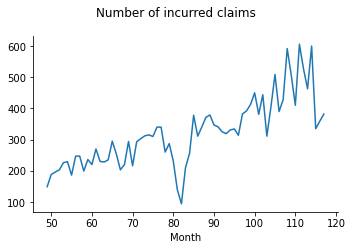

In [3]:
count_nb_claim = aus.groupby('FinMth').count()['AggClaim'].reset_index()
fig, axs = plt.subplots(1,1, figsize=(5, 3.5), tight_layout = True)


axs.plot(count_nb_claim['FinMth'], count_nb_claim['AggClaim'])
axs.set_xlabel('Month')


sns.despine()
plt.suptitle("Number of incurred claims")
plt.savefig("../Figures/monthly_n_claim_aus_en.pdf")


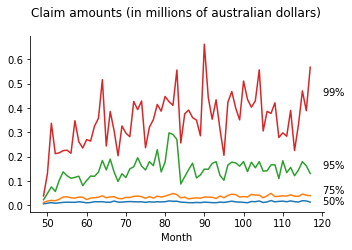

In [4]:
#Rolling mean, median 95 and 99% quantile for years and month
Quantities = ['q50', 'q75', 'q95', 'q99']
Quantity_labels  = ["Quantile à $50\%$",
                   "Quantile à $75\%$",
                   "Quantile à $95\%$",
                   "Quantile à $99\%$"
                  ]
aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
monthly_df = pd.DataFrame({'month':np.unique(aus['FinMth']),
                          'q50':aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.5).values.flatten(), 
                          'q75': aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.75).values.flatten(), 
                          'q95': aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.95).values.flatten(), 
                          'q99' : aus[['FinMth', "scaled_aggclaims"]].groupby('FinMth').quantile(0.99).values.flatten()}
                        )

fig, axs = plt.subplots(1,1, figsize=(5, 3.5), tight_layout = True)

for k, quantity in enumerate(Quantities):
    axs.plot(monthly_df['month'], monthly_df[quantity], label = Quantity_labels[k])
axs.set_xlabel('Month')


axs.text(120, 0.005,'$50\%$', fontsize = 10)
axs.text(120, 0.05,'$75\%$', fontsize = 10)
axs.text(120, 0.15,'$95\%$', fontsize = 10)
axs.text(120, 0.45,'$99\%$', fontsize = 10)
sns.despine()
plt.suptitle("Claim amounts (in millions of australian dollars)")
plt.savefig("../Figures/monthly_rolling_quantile_aus_en.pdf")


In [5]:
np.random.seed(333)
# Prior settings
months = np.unique(aus['FinMth'])
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
traces_monthly, summaries_monthly = [], []
for month in months:
    print("Fitting month "+str(month))
    selec = aus['FinMth'].values == month
    X = aus['scaled_aggclaims'].iloc[selec].values
    model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
    # SMC settings
    popSize, verbose, smc_method, paralell, nproc = 1000, False, "likelihood_anealing", True, 20
    start_time = time()
    traces_month, summary_month = fit_composite_models_smc(X, loss_models, model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
    print("Time: "+str(time() -  start_time))
    summary_month['month'] = month
    traces_monthly.append(traces_month)
    summaries_monthly.append(summary_month)

Fitting month 49
Time: 181.84180402755737
Fitting month 50
Time: 99.03445386886597
Fitting month 51
Time: 91.4346194267273
Fitting month 52
Time: 193.44999957084656
Fitting month 53
Time: 196.61466073989868
Fitting month 54
Time: 194.20714211463928
Fitting month 55
Time: 190.06396889686584
Fitting month 56
Time: 180.64825868606567
Fitting month 57
Time: 154.74153876304626
Fitting month 58
Time: 130.86449098587036
Fitting month 59
Time: 147.8844952583313
Fitting month 60
Time: 141.63867282867432
Fitting month 61
Time: 137.09449315071106
Fitting month 62
Time: 143.62707591056824
Fitting month 63
Time: 139.94375038146973
Fitting month 64
Time: 102.9066174030304
Fitting month 65
Time: 106.76430296897888
Fitting month 66
Time: 108.94239783287048
Fitting month 67
Time: 107.88566422462463
Fitting month 68
Time: 100.64893054962158
Fitting month 69
Time: 118.21753644943237
Fitting month 70
Time: 100.41228914260864
Fitting month 71
Time: 116.68914151191711
Fitting month 72
Time: 120.453018665313

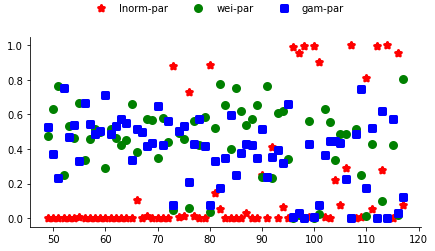

In [27]:
summaries_df = pd.concat(summaries_monthly)
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
markers = ["*", "o", "s"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df['loss_model'].values == loss_model
#     plt.plot(summaries_df['month'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df['month'].iloc[selec].values, summaries_df['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_1_en.pdf")

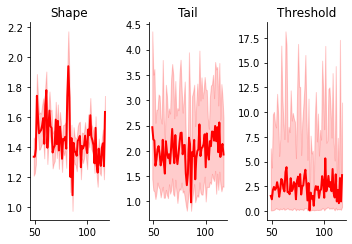

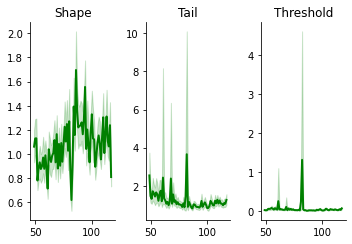

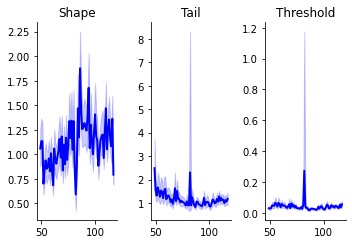

In [28]:
parms_names = ["shape", "tail", "thres"]
title_labs = ["Shape", "Tail", "Threshold"]
for j, loss_model in enumerate(loss_models):
    df_list = []
    for k, month in enumerate(months):
        df = traces_monthly[k][loss_model]
        df['month'] = np.repeat(month, popSize)
        df_list.append(df)
    df_trace = pd.concat(df_list)
    q5 = df_trace.groupby('month').quantile(0.05)
    MAP =df_trace.groupby('month').mean()
    q95 = df_trace.groupby('month').quantile(0.95)
    fig, axs = plt.subplots(1,3, figsize=(5, 3.5), tight_layout = True)
    for k, parm_name in enumerate(parms_names):
        axs[k].plot(months, MAP[parm_name], color = colors[j], linewidth=2)
        axs[k].fill_between(months, q5[parm_name].values, q95[parm_name].values, alpha=0.2, color = colors[j])
        axs[k].set_title(title_labs[k])
    sns.despine()
    plt.savefig("../Figures/monthly_post_map_"+str(loss_model)+"_aus_data_en.pdf")

In [29]:
summaries_df['index'] = np.arange(0, len(months) * 3, 1)
VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df['loss_model'].iloc[k], summaries_df[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df))]), 
                        index = np.arange(0, len(months) * 3, 1))
VaRs.columns = ['q95_compo', 'q99_compo']

quantile_df = pd.merge(summaries_df, VaRs.reset_index()).set_index('index')

quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']

q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['month',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df = pd.concat([q_compo, q_ens, q_emp])
q_df


,month,loss_model,q95,q99
0,49,lnorm-par,0.168308,0.418944
1,49,wei-par,0.027394,0.051569
2,49,gam-par,0.027766,0.053075
3,50,lnorm-par,0.200203,0.500213
4,50,wei-par,0.053895,0.161928
...,...,...,...,...
64,113,empirical,0.121866,0.225592
65,114,empirical,0.145405,0.332090
66,115,empirical,0.179807,0.470364
67,116,empirical,0.162538,0.388811


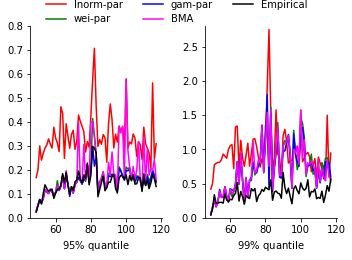

In [30]:
loss_models, colors, model_labs = ["lnorm-par", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm-par", "wei-par", "gam-par","BMA", "Empirical"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df['loss_model'].values == loss_model
    axs[0].plot(q_df['month'].iloc[selec], q_df['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("$95\%$ quantile")
    axs[1].plot(q_df['month'].iloc[selec], q_df['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("$99\%$ quantile")

axs[0].set_ylim([0, 0.8])
axs[1].set_ylim([0, 2.8])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.45, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_1_en.pdf")

# SMC inference of the Weibull-Pareto and gamma-Pareto composite models without lognormal-Pareto

In [31]:
selec = np.array(summaries_df.loss_model == "wei-par") | np.array(summaries_df.loss_model == "gam-par")
df = summaries_df.iloc[selec]
log_marg_df = df[['month', 'log_marg']].groupby('month').max('log_marg').rename(columns = {'log_marg':'max_log_marg'})
df = pd.merge(df, log_marg_df.reset_index(), on = 'month')
df['marg'] =  np.exp(df.log_marg - df.max_log_marg)
marg_df = df[['month', 'marg']].groupby('month').sum('marg').reset_index().rename(columns = {'marg' : "sum_marg"})
df = pd.merge(df, marg_df, on = 'month')
df['model_evidence'] = df.marg / df.sum_marg
summaries_df_2 = df[['month', 'loss_model','log_marg', 'DIC', "WAIC", "model_evidence"] + parms_names ]
summaries_df_2

,month,loss_model,log_marg,DIC,WAIC,model_evidence,shape,tail,thres
0,49,wei-par,536.984208,-1103.145762,-1089.825251,0.472590,1.061724,2.544064,0.028108
1,49,gam-par,537.093959,-1103.087585,-1089.067584,0.527410,1.058578,2.484272,0.028910
2,50,wei-par,589.133587,-1208.352838,-1195.989322,0.630216,1.129564,1.462976,0.023767
3,50,gam-par,588.600443,-1208.611678,-1194.860218,0.369784,1.134992,1.539947,0.027284
4,51,wei-par,563.927125,-1158.277458,-1145.565387,0.766540,1.130673,1.316074,0.026936
...,...,...,...,...,...,...,...,...,...
133,115,gam-par,714.827874,-1460.967875,-1448.136958,0.575109,1.082578,1.115991,0.051895
134,116,wei-par,815.446926,-1662.957586,-1650.400629,0.383681,1.239307,1.056785,0.033745
135,116,gam-par,815.920879,-1664.442516,-1652.155211,0.616319,1.362412,1.061594,0.035815
136,117,wei-par,921.683415,-1874.116719,-1862.823853,0.870348,0.810335,1.260189,0.072405


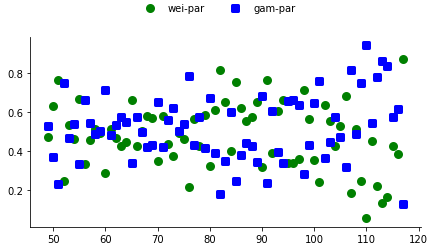

In [32]:
linestyles = ['dashed', 'dotted']
colors = ["green", "blue"]
markers = ["o", "s"]
loss_models = ['wei-par', "gam-par"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_2['loss_model'].values == loss_model
#     plt.plot(summaries_df_2['month'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_2['month'].iloc[selec].values, summaries_df_2['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], ncol = 2, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_2_en.pdf")

In [33]:
parms_names = ["shape", "tail", "thres"]

VaRs = pd.DataFrame(np.array([[quantile_compo(0.95, summaries_df_2['loss_model'].iloc[k], 
                                              summaries_df_2[parms_names].iloc[k].values), 
     quantile_compo(0.99, summaries_df_2['loss_model'].iloc[k], summaries_df_2[parms_names].iloc[k].values )] 
                              for k in range(len(summaries_df_2))]), 
                        index = np.arange(0, len(months) * 2, 1))
VaRs.columns = ['q95_compo', 'q99_compo']

quantile_df = pd.merge(summaries_df_2.reset_index(), VaRs.reset_index()).set_index('index')

quantile_df['q95_weighted'] = quantile_df['q95_compo'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99_compo'] * quantile_df['model_evidence']

q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().rename(columns = {"q95_weighted":"q95",
                                                                                                                    "q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))
q_compo = quantile_df[['month',"loss_model", "q95_compo","q99_compo"] ].rename(columns = {"q95_compo":"q95","q99_compo":"q99"})
q_df_2 = pd.concat([q_compo, q_ens, q_emp])


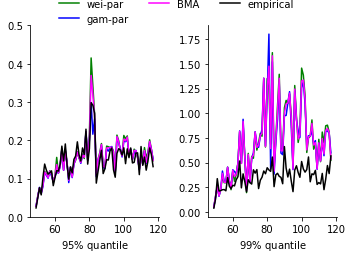

In [34]:
loss_models, colors, model_labs = [ "wei-par", "gam-par", "ensemble", "empirical"] ,\
["green", "blue","magenta", "black"] , [ "wei-par", "gam-par","BMA", "empirical"]
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_2['loss_model'].values == loss_model
    axs[0].plot(q_df_2['month'].iloc[selec], q_df_2['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("$95\%$ quantile")
    axs[1].plot(q_df_2['month'].iloc[selec], q_df_2['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("$99\%$ quantile")

axs[0].set_ylim([0, 0.5])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.43, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_2_en.pdf")

# SMC inference of lognormal model to be compared with the weibull and gamma models

In [35]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

In [11]:
traces_lnorm = []
for month in months:
    print("Fitting month "+str(month))
    selec = aus['FinMth'].values == month
    X = aus['scaled_aggclaims'].iloc[selec].values
    with pm.Model() as model_sev:
        μ = pm.Normal("mu",mu=0, sigma=10)
        σ = pm.Gamma("sig",alpha = 0.1, beta = 0.1)
        U = pm.Lognormal("U", mu=μ, sigma=σ, observed=X)
        %time trace = pm.sample_smc(popSize, random_seed=333, chains = 1)
        traces_lnorm.append(trace)

Fitting month 49
CPU times: user 15.3 s, sys: 1.08 s, total: 16.4 s
Wall time: 4.68 s
Fitting month 50
CPU times: user 18.6 s, sys: 1.21 s, total: 19.8 s
Wall time: 3.61 s
Fitting month 51
CPU times: user 21.1 s, sys: 1.27 s, total: 22.4 s
Wall time: 3.55 s
Fitting month 52
CPU times: user 23.2 s, sys: 1.36 s, total: 24.5 s
Wall time: 4.28 s
Fitting month 53
CPU times: user 16.7 s, sys: 1.05 s, total: 17.7 s
Wall time: 3.63 s
Fitting month 54
CPU times: user 24.3 s, sys: 1.41 s, total: 25.7 s
Wall time: 3.76 s
Fitting month 55
CPU times: user 22.8 s, sys: 1.35 s, total: 24.1 s
Wall time: 3.53 s
Fitting month 56
CPU times: user 23.9 s, sys: 1.39 s, total: 25.3 s
Wall time: 3.62 s
Fitting month 57
CPU times: user 23.6 s, sys: 1.3 s, total: 24.9 s
Wall time: 3.5 s
Fitting month 58
CPU times: user 23.5 s, sys: 1.51 s, total: 25 s
Wall time: 3.44 s
Fitting month 59
CPU times: user 24 s, sys: 1.34 s, total: 25.3 s
Wall time: 3.51 s
Fitting month 60
CPU times: user 22.1 s, sys: 1.44 s, total:

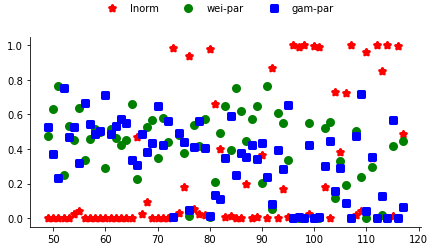

In [36]:
loss_models = ["lnorm", "wei-par", "gam-par"]
linestyles = ['solid', 'dashed', 'dotted']
colors = ['red', "green", "blue"]
markers = ["*", "o", "s"]
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

for k, loss_model in enumerate(loss_models):
    selec = summaries_df_3['loss_model'].values == loss_model
#     plt.plot(summaries_df_3['month'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
#              label = loss_model, linestyle = linestyles[k], color = colors[k], lw=3)
    plt.scatter(summaries_df_3['month'].iloc[selec].values, summaries_df_3['model_evidence'].iloc[selec].values,
             label = loss_model, color = colors[k], lw=3, marker = markers[k])
#     plt.xticks(summaries_df_3['month'].iloc[selec].values)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_model_evidence_aus_data_3_en.pdf")

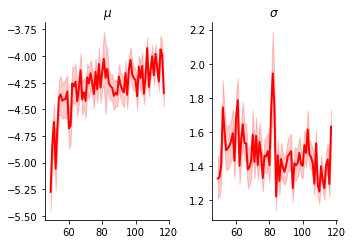

In [37]:
list_df = []
for i in range(len(traces_lnorm)):
    res = pd.DataFrame({
        "mu":traces_lnorm[i]["mu"],
        "sig": traces_lnorm[i]["sig"]})
    res["month"] = months[i]
    list_df.append(res)
traces_lnorm_df = pd.concat(list_df)

parms_names = ["mu", "sig"]
title_labs = ["$\mu$", "$\sigma$"]

q5 = traces_lnorm_df.groupby('month').quantile(0.05)
MAP =traces_lnorm_df.groupby('month').mean()
q95 = traces_lnorm_df.groupby('month').quantile(0.95)
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, parm_name in enumerate(parms_names):
    axs[k].plot(months, MAP[parm_name], color = 'red', linewidth=2)
    axs[k].fill_between(months, q5[parm_name].values, q95[parm_name].values, alpha=0.2, color = "red")
    axs[k].set_title(title_labs[k])
sns.despine()
plt.savefig("../Figures/monthly_post_map_lnorm_aus_data_en.pdf")

In [38]:
list_q = []
map_lnorm = traces_lnorm_df.groupby('month').mean().reset_index()
for k in range(len(months)):
    mu, sig = map_lnorm[["mu", "sig"]].iloc[k]
    res = st.lognorm(s = sig , scale = np.exp(mu)).ppf([0.95, 0.99])
    list_q.append(res)
q_lnorm = pd.DataFrame(np.vstack(list_q), columns = ["q95", "q99"])
q_lnorm["month"] = months
q_lnorm["loss_model"] = np.repeat("lnorm", len(months))
q_lnorm
selec = np.array(q_df_2['loss_model'] == "wei-par") | np.array(q_df_2['loss_model'] == "gam-par") 
q_compo = q_df_2.iloc[selec]
quantile_df = pd.merge(summaries_df_3[["loss_model", "month", "model_evidence"]], pd.concat([q_lnorm, q_compo]), 
         on = ["loss_model", "month"] )
quantile_df['q95_weighted'] = quantile_df['q95'] * quantile_df['model_evidence']
quantile_df['q99_weighted'] = quantile_df['q99'] * quantile_df['model_evidence']
q_ens = quantile_df[['month', 'q95_weighted', 'q99_weighted']].groupby('month').sum().reset_index().\
rename(columns = {"q95_weighted":"q95","q99_weighted":"q99"})
q_ens['loss_model'] = np.repeat('ensemble', len(q_ens))
q_emp = pd.DataFrame(monthly_df[['month', "q95", "q99"]])
q_emp['loss_model'] = np.repeat('empirical', len(q_emp))

q_df_3 = pd.concat([q_compo, q_lnorm, q_ens, q_emp])

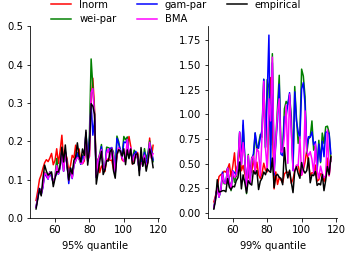

In [39]:
# loss_models, colors, model_labs = ["lnorm",  "empirical"] ,\
# ["red", "black"] , ["lnorm", "Empirique"]
loss_models, colors, model_labs = ["lnorm", "wei-par", "gam-par", "ensemble", "empirical"] ,\
["red", "green", "blue","magenta", "black"] , ["lnorm", "wei-par", "gam-par","BMA", "empirical"]

fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout = True)
for k, loss_model in enumerate(loss_models):
    selec = q_df_3['loss_model'].values == loss_model
    axs[0].plot(q_df_3['month'].iloc[selec], q_df_3['q95'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[0].set_xlabel("$95\%$ quantile")
    axs[1].plot(q_df_3['month'].iloc[selec], q_df_3['q99'].iloc[selec], label = model_labs[k],color = colors[k])
    axs[1].set_xlabel("$99\%$ quantile")

axs[0].set_ylim([0, 0.5])
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=-0.45, loc='upper center', 
           frameon=False)
sns.despine()
plt.savefig("../Figures/monthly_q_compo_aus_data_3_en.pdf")